We start with a simple polynomial in order to verify that our methods work

In [1]:
def simple_poly(x):
    return 4 - 3*x + 2 * x**2

In [2]:
from Gradients import Gradients

## Gradient descent with constant learning rate

In [3]:
from Schedules import Constant
import jax.numpy as np
import numpy as snp
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
%matplotlib inline

snp.random.seed(2023)

__Calibrating the learning rate__

Using the analytical derivative

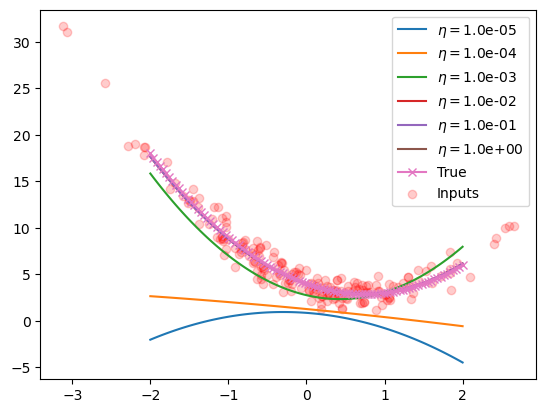

In [4]:
n_epochs = 400
n = 200
x_vals = snp.random.randn(n)
y_vals = simple_poly(x_vals) + snp.random.randn(n)
etas = np.logspace(-5, 0, 6, dtype=np.float64)
theta = snp.random.randn(3)

xnew = np.linspace(-2, 2, 100)

thetas = []
errors = []
base_theta = snp.random.randn(3)

for eta in etas:
    scheduler = Constant(eta)
    Gradient = Gradients(n, x_vals, y_vals, model="OLS", method="analytic", scheduler=scheduler)
    theta = Gradient.GradientDescent(base_theta, n_epochs)
    thetas.append(theta)
    errors.append(Gradient.errors)

for eta, theta in zip(etas, thetas):
    ynew = Gradient.predict(xnew, theta)
    plt.plot(xnew, ynew, label=rf"$\eta=${eta:.1e}")

plt.plot(xnew, simple_poly(xnew), "x-", label="True")
plt.scatter(x_vals, y_vals, color="r", label="Inputs", alpha=0.2)
plt.legend()
plt.show()

In [5]:
n_points = 75
theta_arr = snp.zeros((n_points, 3))
error_arr = snp.zeros((n_points, n_epochs))
eta_arr = np.logspace(-5, -0.75, n_points)

base_theta = snp.random.randn(3)
for i, eta in enumerate(eta_arr):
    scheduler = Constant(eta)
    Gradient = Gradients(n, x_vals, y_vals, model="OLS", method="analytic", scheduler=scheduler)
    theta = Gradient.GradientDescent(base_theta, n_epochs)
    theta_arr[i, :] = theta
    error_arr[i, :] = Gradient.errors

In [6]:
def plot_thetas(theta_arr, x_vals, xscale="linear"):
    "Plots the first three values of theta"
    plt.plot(x_vals, theta_arr[:, 0], color="C1")
    plt.plot(x_vals, theta_arr[:, 1], color="C2")
    plt.plot(x_vals, theta_arr[:, 2], color="C3")
    plt.xscale(xscale)
    plt.axhline(4, color="C1", linestyle=':', label=r"$\theta_0$")
    plt.axhline(-3, color="C2", linestyle=':', label=r"$\theta_1$")
    plt.axhline(2, color="C3", linestyle=':', label=r"$\theta_2$")
    
    plt.legend()

## $\theta$ as a function of $\eta$

As we see below, our predicted parameters $\theta$ are highly dependent on our choice of $\eta$. The plot is cutoff, as too high values of $\eta$ causes overflow.

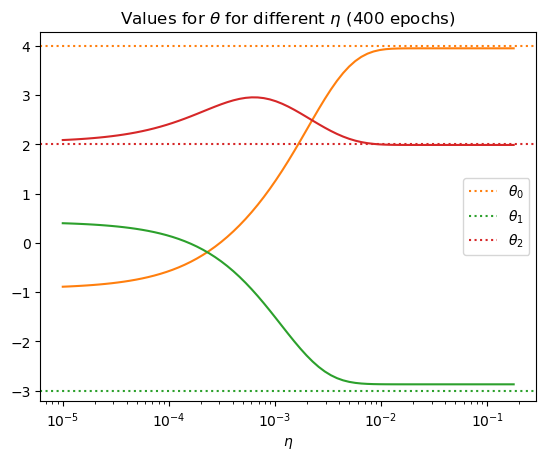

In [7]:
plot_thetas(theta_arr, eta_arr, xscale="log")
plt.xlabel(r"$\eta$")
plt.title(fr"Values for $\theta$ for different $\eta$ ({n_epochs} epochs)")
plt.show()

In [8]:
def predict_per_theta(theta_arr):
    ynew_vals = snp.zeros((len(theta_arr), 100))

    for i, theta in enumerate(theta_arr):
        ynew = Gradient.predict(xnew, theta)
        ynew_vals[i] = ynew
    
    return ynew_vals


In [9]:
def plot_pred_per_eta(xnew, ynew_vals, eta_arr, func=simple_poly):
    from matplotlib import colormaps
    import matplotlib as mpl

    fig, ax = plt.subplots()

    cmap = colormaps.get_cmap("viridis")
    norm = mpl.colors.LogNorm(vmin=eta_arr[0], vmax=eta_arr[-1])

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    ax.set_xlim(np.min(xnew), np.max(xnew))
    ax.set_ylim(np.min(ynew_vals), np.max(ynew_vals))

    for i, ynew in enumerate(ynew_vals):
        ax.plot(xnew, ynew, color=cmap(norm(eta_arr[i])))

    ax.plot(xnew, func(xnew), ":", color="k", label="True")
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    plt.title("Predicted polynomials")
    plt.legend()
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel(r"$\eta$", rotation=0, fontsize='large')
    plt.show()

In [10]:
def plot_error_per_eta(error_arr, eta_arr):
    from matplotlib import colormaps
    import matplotlib as mpl

    fig, ax = plt.subplots()

    cmap = colormaps.get_cmap("viridis")
    norm = mpl.colors.LogNorm(vmin=eta_arr[0], vmax=eta_arr[-1])

    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    ax.set_xlim(0, error_arr.shape[1])
    ax.set_ylim(np.min(error_arr), np.max(error_arr))

    for i, error in enumerate(error_arr):
        ax.plot(error, color=cmap(norm(eta_arr[i])))

    # ax.plot(xnew, func(xnew), ":", color="k", label="True")
    ax.set_xlabel(r"$n_{epochs}$")
    ax.set_ylabel("MSE")
    plt.title("Training error per epoch")
    plt.legend()
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel(r"$\eta$", rotation=0, fontsize='large')
    plt.show()

To get a more visual understanding of how $\eta$ effects the resulting predictions, I have genereted the plot below. Here we see that the higher values of $\eta$ place us closer to the true line, marked with dots.

/var/folders/gk/nd3wqtqx291b3hj52v6ll0qw0000gn/T/ipykernel_997/803472712.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


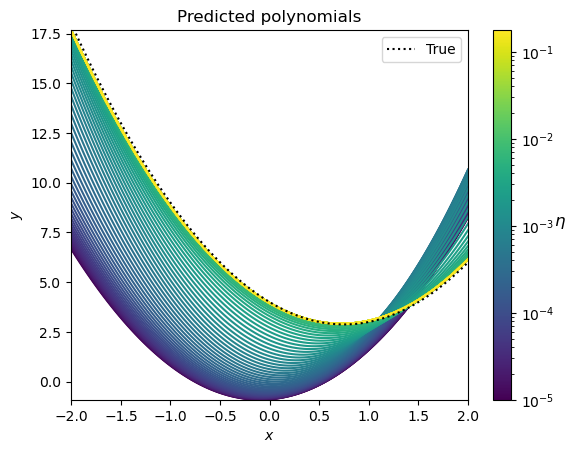

In [11]:
ynew_vals = predict_per_theta(theta_arr)
plot_pred_per_eta(xnew, ynew_vals, eta_arr)

/var/folders/gk/nd3wqtqx291b3hj52v6ll0qw0000gn/T/ipykernel_997/2935352217.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


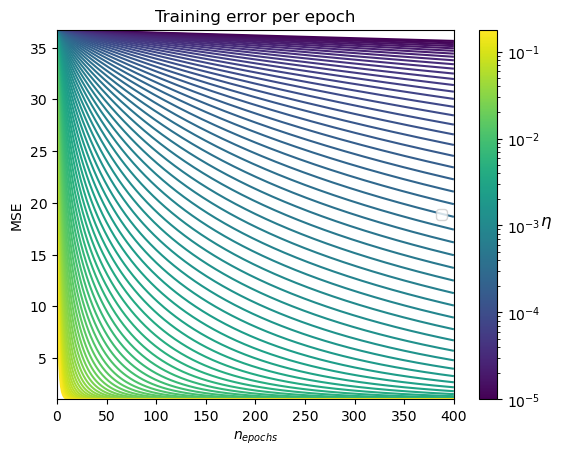

In [12]:
plot_error_per_eta(error_arr, eta_arr)

# Adding momentum

In [13]:
from Schedules import Momentum

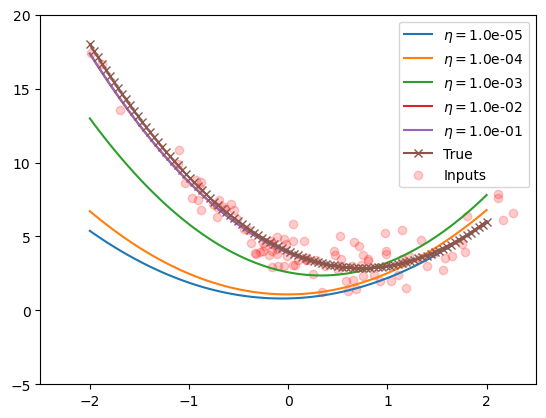

In [14]:
n_epochs = 500
n = 100
x_vals = snp.random.randn(n)
y_vals = simple_poly(x_vals) + snp.random.randn(n)
etas = snp.logspace(-5, -1, 5, dtype=np.float64)
theta = snp.random.randn(3)

xnew = snp.linspace(-2, 2, n)

thetas = []
base_theta = snp.random.randn(3)
error_arr = []

for eta in etas:
    scheduler = Momentum(eta, 0.1)
    Gradient = Gradients(n, x_vals, y_vals, model="OLS", method="analytic", scheduler=scheduler)
    theta = Gradient.GradientDescent(base_theta, n_epochs)
    thetas.append(theta)
    error_arr.append(Gradient.errors)

for eta, theta in zip(etas, thetas):
    ynew = Gradient.predict(xnew, theta)
    plt.plot(xnew, ynew, label=rf"$\eta=${eta:.1e}")

plt.plot(xnew, simple_poly(xnew), "x-", label="True")
plt.scatter(x_vals, y_vals, color="r", label="Inputs", alpha=0.2)
plt.ylim(-5, 20)
plt.xlim(-2.5, 2.5)
plt.legend()
plt.show()

In [97]:
# n_points = 200
theta_arr = snp.zeros((n_points, 3))
error_arr = snp.zeros((n_points, n_epochs))
# snp.random.seed(2018)

# x_vals = snp.random.randn(n)
# y_vals = simple_poly(x_vals) + snp.random.randn(n)

# base_theta = snp.random.randn(3)
# n_epochs = 500

moment_arr = snp.linspace(1/n_points, 1, n_points)

for i, moment in enumerate(moment_arr):
    scheduler = Momentum(0.001, moment)
    Gradient = Gradients(n, x_vals, y_vals, model="OLS", method="analytic", scheduler=scheduler)
    theta = Gradient.GradientDescent(base_theta, n_epochs)
    theta_arr[i, :] = theta
    error_arr[i, :] = Gradient.errors


/var/folders/gk/nd3wqtqx291b3hj52v6ll0qw0000gn/T/ipykernel_997/803472712.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


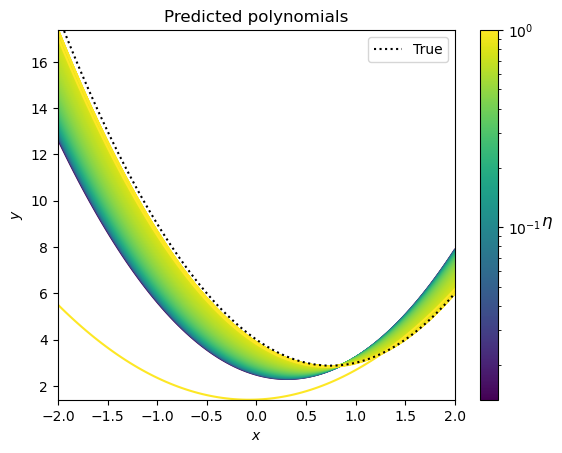

In [98]:
ynew_vals = predict_per_theta(theta_arr)
plot_pred_per_eta(xnew, ynew_vals, moment_arr)

/var/folders/gk/nd3wqtqx291b3hj52v6ll0qw0000gn/T/ipykernel_997/2935352217.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


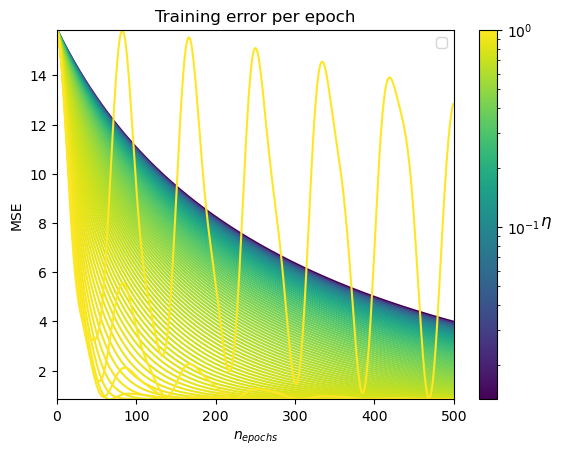

In [99]:
plot_error_per_eta(error_arr, moment_arr)

In [100]:
moment_arr.shape

(75,)

Text(0.5, 1.0, 'Values for $\\theta$ for momentum (500 epochs)')

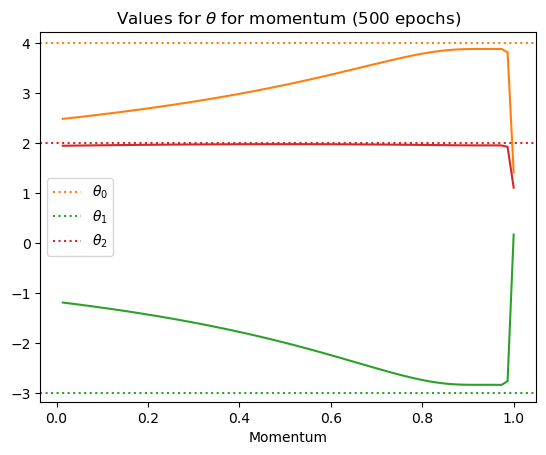

In [101]:
plot_thetas(theta_arr, moment_arr, xscale="linear")
plt.xlabel("Momentum")
plt.title(fr"Values for $\theta$ for momentum ({n_epochs} epochs)")

In [86]:
from sklearn.metrics import mean_squared_error
from Schedules import Momentum
from Gradients import Gradients
import numpy as snp
import jax.numpy as np
from tqdm import tqdm

n_moment = 75
n_eta = 25
moment_arr = snp.arctan(snp.linspace(0, 10, n_points))
moment_arr = moment_arr / np.max(moment_arr)
eta_arr = snp.logspace(-7, -1, n_eta)
xnew = np.linspace(-2, 2, 100)
ynew = simple_poly(xnew)
n_epochs = 500

errors = snp.zeros((n_moment, n_eta))
iters = snp.zeros((n_moment, n_eta))

pbar = tqdm(total=n_moment * n_eta)
for i, moment in enumerate(moment_arr[::-1]):
    for j, eta in enumerate(eta_arr):
        scheduler = Momentum(eta, moment)
        Gradient = Gradients(n, x_vals, y_vals, model="OLS", method="analytic", scheduler=scheduler)
        theta = Gradient.GradientDescent(base_theta, n_epochs)
        ypred = Gradient.predict(xnew, theta)
        errors[i, j] = mean_squared_error(ynew, ypred)
        pbar.update(1)

Text(0.5, 1.0, 'Mean squared error')

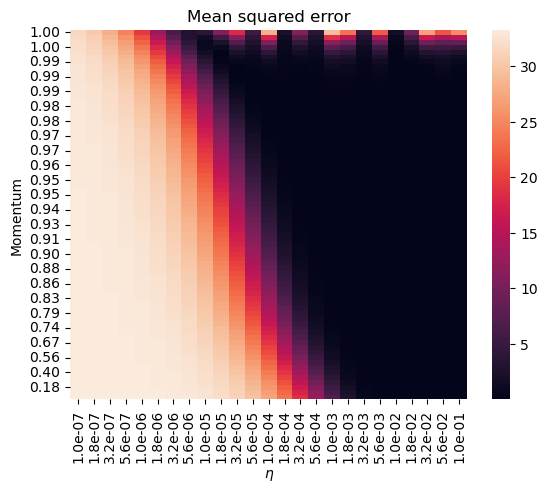

In [87]:
import seaborn as sns
import pandas as pd

df = pd.DataFrame(errors, index=[f"{moment:.2f}" for moment in moment_arr[::-1]], columns=[f"{eta:.1e}" for eta in eta_arr])

ax = sns.heatmap(df)
ax.set_xlabel(r"$\eta$")
ax.set_ylabel("Momentum")
ax.set_title("Mean squared error")